Что сделать?
+ импортировать(!!!), установив свой пакет мутспек в био-енв, класс для парсинга кодонов
+ залить туда функцию парсинга генбанка
+ заменить глупые is_syn & is_ff на стандартный лейбл, там лежит функция ~ get_mut_type
+ получить частоты тринуклеотидов и нуклеотидов простым подсчетом из Ref таблицы
+ воспользоваться уже написанной функцией подсчета мутспека. Ее нужно подправить - добавить вариант когда нужно считать дискретные состояния, а не вероятности, еще один аргумент
+ развернуть мутспек потому что он опять посчитан на L цепи, а надо перевести в H

- Поделить на H & L
- Разложить на подписи

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec.utils import (
    read_genbank_ref, calculate_mutspec, CodonAnnotation, 
    possible_codons, possible_sbs12, possible_sbs192,
)
from mutspec.utils.annot import mutations_summary, translator, rev_comp

sns.set_style()

## Observed mutations

In [2]:
# df = pd.read_csv(path_to_obs, sep="\t")
# df[['position', 'ref', 'var', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37']].to_csv("../data/processed/context.csv", index=None)

In [3]:
##### read observed and merge it with annotation in order to annotate
path_to_obs = "../data/1raw/mtDNA_snv_Oct2016.txt"
_cols = "position,ref,var,Tier2,Annot,tumor_var_freq,is_nonsense,Unnamed: 36".split(",")
ObsAll = pd.read_csv(path_to_obs, sep="\t", usecols=_cols)

ObsAll.rename(columns={"Tier2": "tissue", "Unnamed: 36": "sbs_raw"}, inplace=True)

def replace_sbs(sbs: str):
    new_sbs = sbs[1] + "[" + sbs[2:5] + "]" + sbs[-1]
    if sbs.startswith("p"):
        pass
    elif sbs.startswith("n"):
        new_sbs = rev_comp(new_sbs)
    return new_sbs

ObsAll["sbs"] = ObsAll["sbs_raw"].apply(replace_sbs)
ObsAll["tumor_var_freq"] = ObsAll["tumor_var_freq"].str.rstrip("%").astype(np.float)

print(ObsAll.shape)
ObsAll.head()

(7611, 9)


,tissue,position,ref,var,tumor_var_freq,Annot,sbs_raw,is_nonsense,sbs
0,Bladder,2680,T,C,38.79,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",pTT>CG,0,T[T>C]G
1,Bladder,6011,T,C,10.14,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",pTT>CA,0,T[T>C]A
2,Bladder,7706,G,A,37.39,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",nGC>TA,0,T[G>A]C
3,Bladder,9078,T,C,86.55,"synSNP,MT-ATP6,MT-ATP6,exon1,I184I,5,1;",pTT>CA,0,T[T>C]A
4,Bladder,9686,T,C,1.85,"synSNP,MT-CO3,MT-CO3,exon1,I160I,5,5;",pTT>CC,0,T[T>C]C


### Add cell TurnOverDays columns

In [4]:
CancerTissue = ('Bladder','Bone/SoftTissue','Breast','Biliary','Cervix','Lymphoid','Myeloid','Colon/Rectum','Prostate','Esophagus','Stomach','CNS','Head/Neck','Kidney','Liver','Lung','Ovary','Pancreas','Skin','Thyroid','Uterus')  
TurnOverDays = (200,5373,84.5,200,6,30,30,5,120,11,5.5,10000,16,1000,400,5143,11000,360,147,4138,4)
_turn_mapper = dict(zip(CancerTissue, TurnOverDays))
Turn = pd.Series(_turn_mapper).sort_values().reset_index().rename(columns={"index": "tissue", 0: "TurnOverDays"})
# Turn["DummyVerySlowTurnOver"] = Turn["TurnOverDays"] > Turn["TurnOverDays"].quantile(.75)
# Turn["DummySlowTurnOver"] = Turn["TurnOverDays"] > Turn["TurnOverDays"].quantile(.5)
# Turn["DummyNotFastTurnOver"] = Turn["TurnOverDays"] > Turn["TurnOverDays"].quantile(.25)
print(Turn.describe().T)
Turn

              count        mean         std  min   25%    50%     75%      max
TurnOverDays   21.0  1822.52381  3354.87855  4.0  16.0  147.0  1000.0  11000.0


,tissue,TurnOverDays
0,Uterus,4.0
1,Colon/Rectum,5.0
2,Stomach,5.5
3,Cervix,6.0
4,Esophagus,11.0
5,Head/Neck,16.0
6,Lymphoid,30.0
7,Myeloid,30.0
8,Breast,84.5
9,Prostate,120.0


In [5]:
ObsAll = pd.merge(ObsAll, Turn, on="tissue")
assert ObsAll["TurnOverDays"].isna().sum() == 0

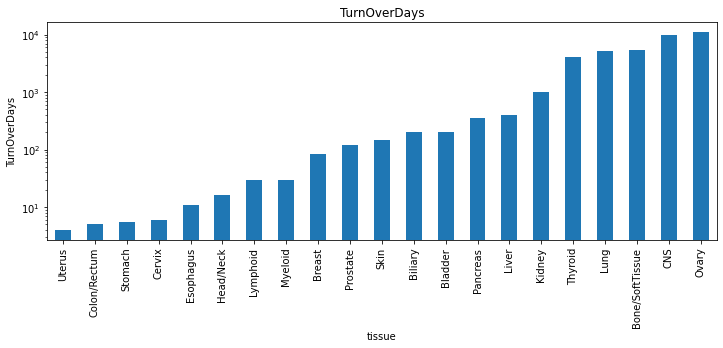

In [6]:
plt.figure(figsize=(12, 4))
plt.title("TurnOverDays")
plt.ylabel("TurnOverDays")
Turn.set_index("tissue").TurnOverDays.plot.bar()
plt.yscale("log")
plt.show()

## Read reference genbank

In [7]:
path_to_gb = "../data/external/NC_012920.1.gb"
Ref = read_genbank_ref(path_to_gb)
print(Ref.shape)
Ref.to_csv("../data/processed/ref_annot.csv", index=None)
Ref.head(4000)

(16569, 9)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...
3995,3996,C,ACA,1,CDS,ND1,690,3,AAC
3996,3997,A,CAT,1,CDS,ND1,691,1,ATT
3997,3998,T,ATT,1,CDS,ND1,692,2,ATT
3998,3999,T,TTA,1,CDS,ND1,693,3,ATT


### Derive TBSS for each position, positions within D-loop and Ol will have NA

In [8]:
Ref["TBSS"] = np.nan
Ref["TBSS"].loc[(Ref.Pos > 576) & (Ref.Pos < 5721)] = 16569 - (5721 - Ref.Pos) * 2  # minor arc; L-strand replication origin (locus MT-OLR, 5721 - 5798)
Ref["TBSS"].loc[(Ref.Pos > 5798) & (Ref.Pos < 16024)] = (Ref.Pos - 5798) * 2        # major arc

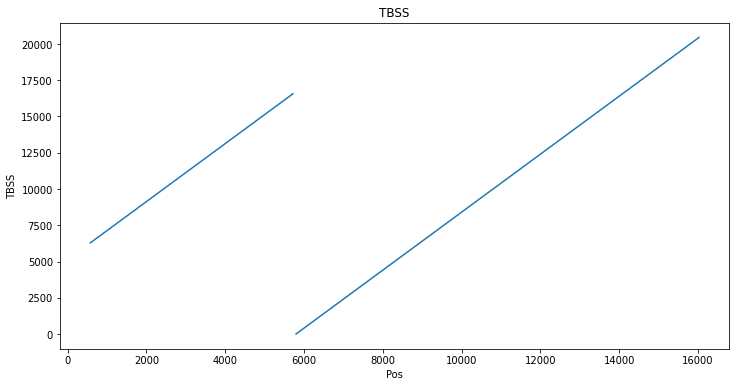

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(Ref.Pos, Ref.TBSS)
plt.title("TBSS")
plt.ylabel("TBSS")
plt.xlabel("Pos")
plt.show()

### Merge mutations and custom annotation from genbank

In [10]:
coda = CodonAnnotation(2)

In [11]:
def get_alt(ser: pd.Series):
    if not isinstance(ser["Codon"], str):
        return None
    codon = list(ser["Codon"])
    ref_nuc, alt_nuc = ser["ref"], ser["var"]
    pic = ser["PosInCodon"] - 1
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon
    
mutations = pd.merge(
    ObsAll[["tissue", "position", "ref", "var", 'sbs', 'TurnOverDays', 'tumor_var_freq']], 
    Ref, left_on=["position", "ref"], right_on=["Pos", "Nuc"],
)
mutations["AltCodon"] = mutations.apply(get_alt, axis=1)
mutations["Label"] = mutations.apply(
    lambda s: 0 if s.PosInCodon <= 0 else coda.get_mut_type(
        s.Codon, s.AltCodon, s.PosInCodon - 1)[0], axis=1)
mutations["Mut"] = mutations.Context.str.get(0) + "[" + mutations["ref"] + ">" + mutations["var"] + "]" + mutations.Context.str.get(-1)

assert len(mutations[mutations.sbs != mutations.Mut]) == 0, "contexts are not equal"

mutations.drop(["position", "ref", "var", "sbs"], axis=1, inplace=True)
mutations.to_csv("../data/processed/mutations.csv", index=None)
print(mutations.shape)
mutations.head()

(7611, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,None,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,None,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


### Describe observed mutations

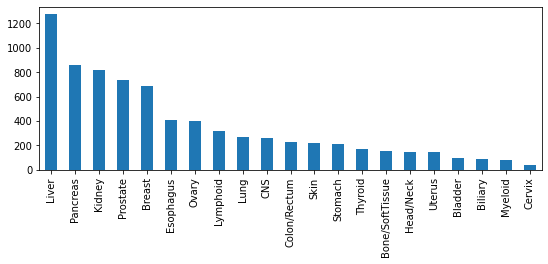

In [12]:
plt.figure(figsize=(9, 3))
mutations.tissue.value_counts().plot.bar();

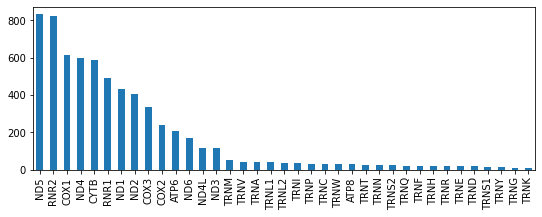

In [13]:
plt.figure(figsize=(9, 3))
mutations.GeneName.value_counts().plot.bar();

In [14]:
mutations.Strand.value_counts()

 1    6209
-1    1359
 0      43
Name: Strand, dtype: int64

In [15]:
mutations.Label.value_counts()

 0    6488
 2     462
 1     373
-1     278
-3      10
Name: Label, dtype: int64

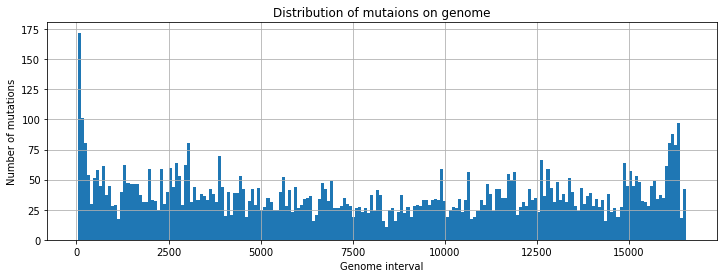

In [16]:
plt.figure(figsize=(12, 4))
plt.title("Distribution of mutaions on genome")
plt.xlabel("Genome interval")
plt.ylabel("Number of mutations")
mutations.Pos.hist(bins=200);

In [17]:
ObsAll.is_nonsense.value_counts()

0    7330
1     281
Name: is_nonsense, dtype: int64

In [18]:
mutations_summary(mutations, gene_col="GeneName")

,non-syn,syn,syn4f,Stop gain,Stop to stop
GeneName,,,,,
ATP6,150,20,31,5,0
ATP8,11,11,2,5,0
COX1,428,52,72,59,0
COX2,184,17,28,9,1
COX3,261,25,22,30,0
CYTB,450,34,49,50,3
ND1,337,30,44,17,3
ND2,285,34,56,27,3
ND3,83,22,7,4,0


## Frequencies counting

In [19]:
ProtRef = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]
ProtRef["SynNum"] = ProtRef.apply(lambda s: coda.get_syn_number(s.Codon, s.PosInCodon - 1), axis=1)
ProtRef

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,SynNum
3306,3307,A,CAT,1,CDS,ND1,1,1,ATA,11741.0,0
3307,3308,T,ATA,1,CDS,ND1,2,2,ATA,11743.0,0
3308,3309,A,TAC,1,CDS,ND1,3,3,ATA,11745.0,1
3309,3310,C,ACC,1,CDS,ND1,4,1,CCC,11747.0,0
3310,3311,C,CCC,1,CDS,ND1,5,2,CCC,11749.0,0
...,...,...,...,...,...,...,...,...,...,...,...
15882,15883,G,GGG,1,CDS,CYTB,1137,3,TGG,20170.0,1
15883,15884,G,GGC,1,CDS,CYTB,1138,1,GCC,20172.0,0
15884,15885,C,GCC,1,CDS,CYTB,1139,2,GCC,20174.0,0
15885,15886,C,CCT,1,CDS,CYTB,1140,3,GCC,20176.0,3


In [20]:
nucl_freqs = {
    "all": ProtRef["Nuc"].value_counts().to_dict(),
    "syn": ProtRef.groupby("Nuc")["SynNum"].sum().to_dict(),
    "ff" : ProtRef[ProtRef["SynNum"] == 3].groupby("Nuc")["SynNum"].sum().to_dict(),
    "D-loop": Ref[Ref.Type == "D-loop"]["Nuc"].value_counts().to_dict(),
    "rRNA": Ref[Ref.Type == "rRNA"]["Nuc"].value_counts().to_dict(),
    "tRNA": Ref[Ref.Type == "tRNA"]["Nuc"].value_counts().to_dict(),
}
nucl_freqs

{'all': {'C': 3583, 'A': 3171, 'T': 2767, 'G': 1295},
 'syn': {'A': 2848, 'C': 3515, 'G': 370, 'T': 1151},
 'ff': {'A': 2304, 'C': 2460, 'G': 288, 'T': 789},
 'D-loop': {'C': 371, 'A': 339, 'T': 260, 'G': 152},
 'rRNA': {'A': 862, 'C': 650, 'T': 549, 'G': 451},
 'tRNA': {'A': 527, 'T': 405, 'C': 353, 'G': 219}}

In [21]:
def complete_trinucl_freqs(trinucl_freqs: dict):
    for lbl,freqs in trinucl_freqs.items():
        for cxt in possible_codons:
            if cxt not in freqs:
                trinucl_freqs[lbl][cxt] = 0
    return trinucl_freqs

In [43]:
trinucl_freqs = {
    "all": ProtRef["Context"].value_counts().to_dict(),
    "syn": ProtRef.groupby("Context")["SynNum"].sum().to_dict(),
    "ff" : ProtRef[ProtRef["SynNum"] == 3].groupby("Context")["SynNum"].sum().to_dict(),
    "D-loop": Ref[Ref.Type == "D-loop"]["Context"].value_counts().to_dict(),
    "ExDloop": Ref[Ref.Type != "D-loop"]["Context"].value_counts().to_dict(),
    "rRNA": Ref[Ref.Type == "rRNA"]["Context"].value_counts().to_dict(),
    "tRNA": Ref[Ref.Type == "tRNA"]["Context"].value_counts().to_dict(),
}
trinucl_freqs = complete_trinucl_freqs(trinucl_freqs)

## Calculate mutspec

In [23]:
MutCDS = mutations[(mutations.Type == "CDS") & (mutations.Strand == 1) & (mutations.Label >= 0)]
print(mutations.shape, MutCDS.shape)

(7611, 16) (4217, 16)


In [24]:
mutspec12 = pd.DataFrame({"Mut": possible_sbs12})
mutspec192 = pd.DataFrame({"Mut": possible_sbs192})

for lbl in nucl_freqs:
    if lbl in {"all", "syn", "ff"}:
        ms12  = calculate_mutspec(MutCDS, nucl_freqs[lbl], lbl, False, False)
        ms192 = calculate_mutspec(MutCDS, trinucl_freqs[lbl], lbl, True, False)
    else:
        MutCustom = mutations[(mutations.Type == lbl)]
        ms12  = calculate_mutspec(MutCDS, nucl_freqs[lbl], "all", False, False)
        ms192 = calculate_mutspec(MutCustom, trinucl_freqs[lbl], "all", True, False)

    ms12.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    ms192.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    mutspec12 = pd.merge(mutspec12, ms12[["Mut", f"MutSpec_{lbl}"]], on="Mut")
    mutspec192 = pd.merge(mutspec192, ms192[["Mut", f"MutSpec_{lbl}"]], on="Mut")

### Reverse complement of Mut

In [25]:
mutspec12["Mut"] = mutspec12.Mut.str.translate(translator)
mutspec192["Mut"] = mutspec192.Mut.apply(rev_comp)

### Count similarities
Without missing data

In [26]:
print("Excluding zeros (missing observations)\n")
print("Labels  \tCos_sim192\tEucDist192")
print("-" * 42)
_lbls = set()
for lbl1 in nucl_freqs:
    _lbls.add(lbl1)
    for lbl2 in nucl_freqs:
        if lbl1 != lbl2 and lbl2 not in _lbls:
            if lbl1 == "ff" or lbl2 == "ff":
                obs_muts = mutspec192.Mut.apply(lambda m: m[0] + m[2] + m[-1]).isin(coda.possible_ff_contexts)
            else:
                obs_muts = mutspec192.Mut.str.len() > 0  # all True

            dst192 = spatial.distance.cosine(
                mutspec192[f"MutSpec_{lbl1}"][obs_muts], mutspec192[f"MutSpec_{lbl2}"][obs_muts]
            )
            sim192 = 1 - dst192
            euc192 = spatial.distance.euclidean(
                mutspec192[f"MutSpec_{lbl1}"][obs_muts], mutspec192[f"MutSpec_{lbl2}"][obs_muts]
            )
            _lbl1 = "allCDS" if lbl1 == "all" else lbl1

            print(f"{_lbl1} & {lbl2}\t{sim192:.3f}\t\t{euc192:.3f}")

Excluding zeros (missing observations)

Labels  	Cos_sim192	EucDist192
------------------------------------------
allCDS & syn	0.832		0.112
allCDS & ff	0.801		0.112
allCDS & D-loop	0.632		0.147
allCDS & rRNA	0.947		0.062
allCDS & tRNA	0.947		0.061
syn & ff	0.659		0.143
syn & D-loop	0.529		0.176
syn & rRNA	0.830		0.114
syn & tRNA	0.856		0.105
ff & D-loop	0.532		0.164
ff & rRNA	0.816		0.108
ff & tRNA	0.818		0.109
D-loop & rRNA	0.616		0.156
D-loop & tRNA	0.606		0.157
rRNA & tRNA	0.894		0.089


### Plot MutSpec

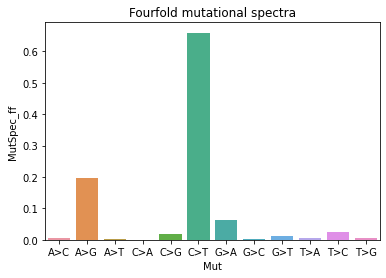

In [27]:
sns.barplot(x="Mut", y="MutSpec_ff", data=mutspec12, order=possible_sbs12)
plt.title("Fourfold mutational spectra")
plt.show()

In [28]:
from itertools import groupby


def _add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def _label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def _label_group_bar_table(ax, df):
    font = {
        'family': 'cursive',
        'color':  'black',
        'weight': 'normal',
        'size': 7,
    }
    rotation = 90
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in _label_len(df.index, level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                _add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            _add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec192, ylabel="MutSpec", title="Mutational spectra", filepath=None):
    edge_mutspec192 = edge_mutspec192.copy()
    edge_mutspec192["Context"] = edge_mutspec192.Mut.apply(lambda x: x[0] + x[2] + x[-1])
    edge_mutspec192["MutBase"] = edge_mutspec192.Mut.apply(lambda x: x[2:5])
    df = edge_mutspec192.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.barplot(x="Mut", y=ylabel, data=edge_mutspec192,
                order=possible_sbs192, errwidth=1, ax=fig.gca())

    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(title)
    _label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


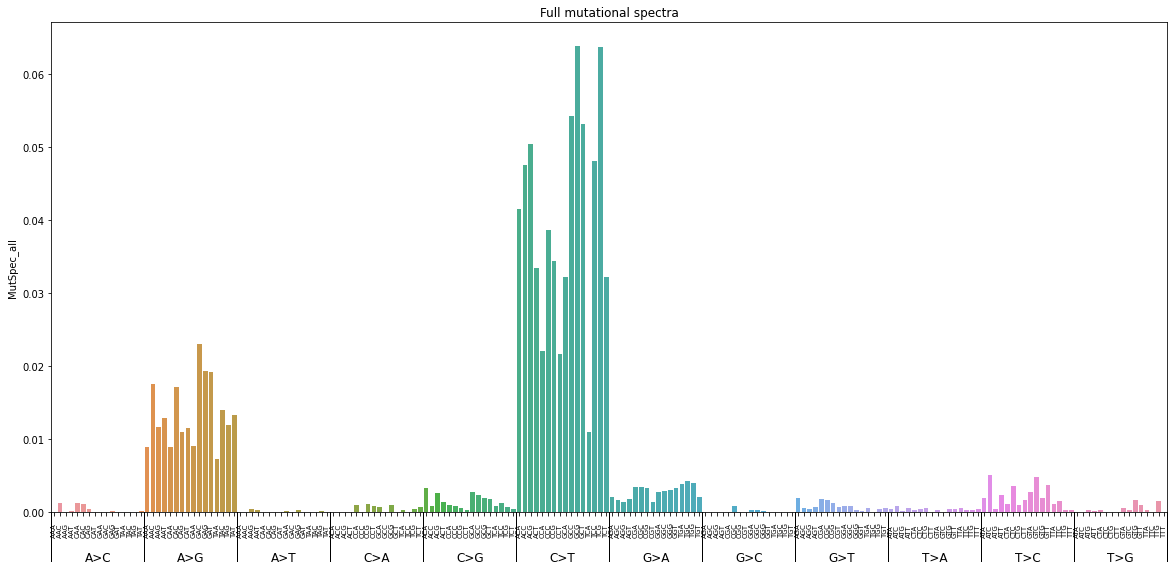

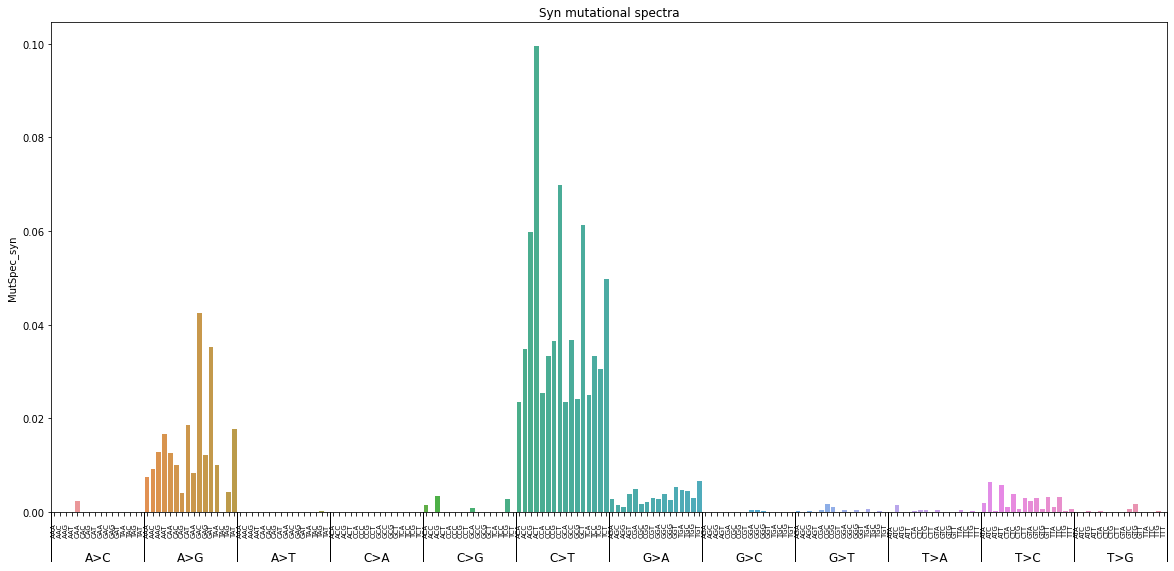

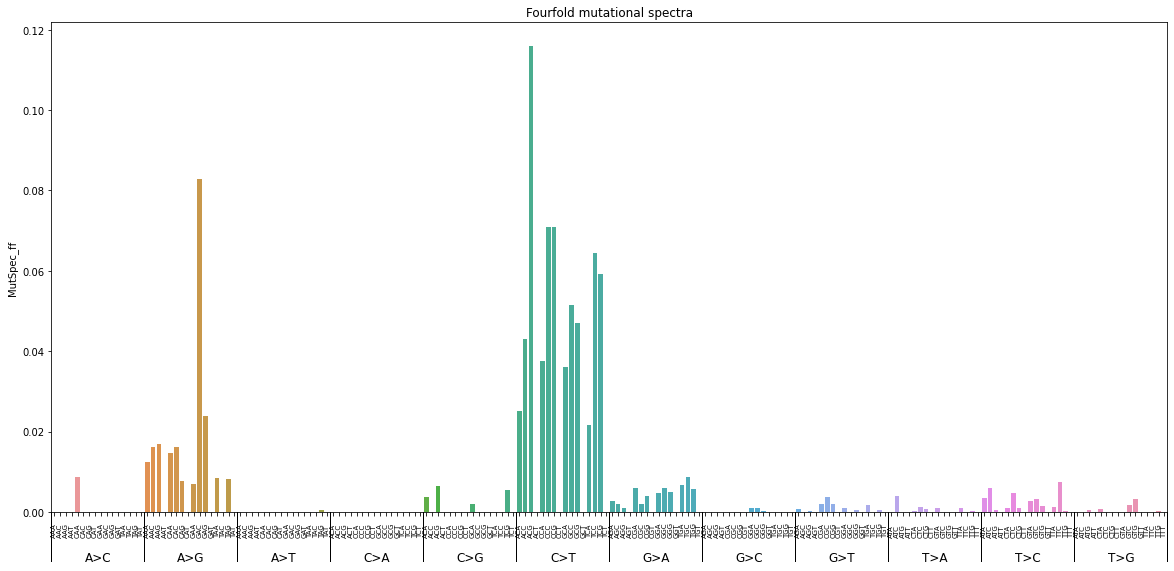

In [31]:
plot_mutspec192(mutspec192, "MutSpec_all", "Full mutational spectra")
plot_mutspec192(mutspec192, "MutSpec_syn", "Syn mutational spectra")
plot_mutspec192(mutspec192, "MutSpec_ff", "Fourfold mutational spectra")

## Check normalization impact on cossim

In [29]:
MutCDS.sample(MutCDS.shape[0] // 3)

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
7581,Uterus,4.0,43.82,8227,T,TTC,1,CDS,COX2,642,3,ATT,4858.0,ATC,1,T[T>C]C
5551,Ovary,11000.0,11.65,7887,G,GGC,1,CDS,COX2,302,2,GGC,4178.0,GAC,0,G[G>A]C
4211,Esophagus,11.0,1.80,12758,T,TTC,1,CDS,ND5,422,2,TTC,13920.0,TCC,0,T[T>C]C
5673,Kidney,1000.0,1.11,11385,T,CTT,1,CDS,ND4,626,2,CTT,11174.0,CCT,0,C[T>C]T
1305,Prostate,120.0,1.25,7658,G,TGA,1,CDS,COX2,73,1,GAT,3720.0,AAT,0,T[G>A]A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,Kidney,1000.0,1.66,13393,G,TGA,1,CDS,ND5,1057,1,GAA,15190.0,AAA,0,T[G>A]A
2137,Breast,84.5,46.22,3732,T,ATG,1,CDS,ND1,426,3,TAT,12591.0,TAC,1,A[T>C]G
2133,Prostate,120.0,1.86,7078,G,GGC,1,CDS,COX1,1175,2,GGC,2560.0,GAC,0,G[G>A]C
416,Liver,400.0,42.38,4794,G,AGC,1,CDS,ND2,325,1,GCC,14715.0,ACC,0,A[G>A]C


In [30]:
_sim_data = []

lbl = "all"
for _ in range(500):
    _mut1 = MutCDS.sample(MutCDS.shape[0] // 3)
    _mut2 = MutCDS.sample(MutCDS.shape[0] // 3)
    ms192normed1 = calculate_mutspec(_mut1, trinucl_freqs[lbl], lbl, True, False)
    ms192normed2 = calculate_mutspec(_mut2, trinucl_freqs[lbl], lbl, True, False)

    _freqs_eq = {x: 1 for x in possible_codons}
    ms192unnormed1 = calculate_mutspec(_mut1, _freqs_eq, lbl, True, False)
    ms192unnormed2 = calculate_mutspec(_mut2, _freqs_eq, lbl, True, False)

    sim_normed   = 1 - spatial.distance.cosine(ms192normed1.sort_values("Mut")["MutSpec"].values, ms192normed2.sort_values("Mut")["MutSpec"].values)
    sim_unnormed = 1 - spatial.distance.cosine(ms192unnormed1.sort_values("Mut")["MutSpec"].values, ms192unnormed2.sort_values("Mut")["MutSpec"].values)
    
    _sim_data.append({
        "normed": sim_normed,
        "unnormed": sim_unnormed,
    })
df_sim = pd.DataFrame(_sim_data)

### Look at one example

In [34]:
# plt.figure(figsize=(20, 6))
# plt.title("normed 1")
# sns.barplot(data=ms192normed1, x="Mut", y="MutSpec", order=possible_sbs192)
# plt.show()

# plt.figure(figsize=(20, 6))
# plt.title("normed 2")
# sns.barplot(data=ms192normed2, x="Mut", y="MutSpec", order=possible_sbs192)
# plt.show()

In [35]:
# plt.figure(figsize=(20, 6))
# plt.title("unnormed 1")
# sns.barplot(data=ms192unnormed1, x="Mut", y="MutSpec", order=possible_sbs192)
# plt.show()

# plt.figure(figsize=(20, 6))
# plt.title("unnormed 2")
# sns.barplot(data=ms192unnormed2, x="Mut", y="MutSpec", order=possible_sbs192)
# plt.show()

### Look at correlation of normed and unnormed similarity

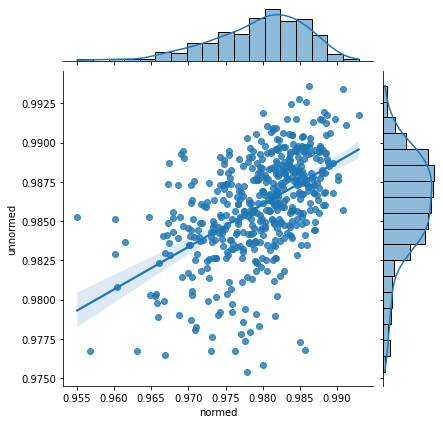

,normed,unnormed
normed,1.000000,0.512741
unnormed,0.512741,1.000000


In [36]:
sns.jointplot("normed", "unnormed", data=df_sim, kind="reg")
plt.show()
df_sim.corr()

## Calculate similarities using hypoxia features

### Explorary features analysis

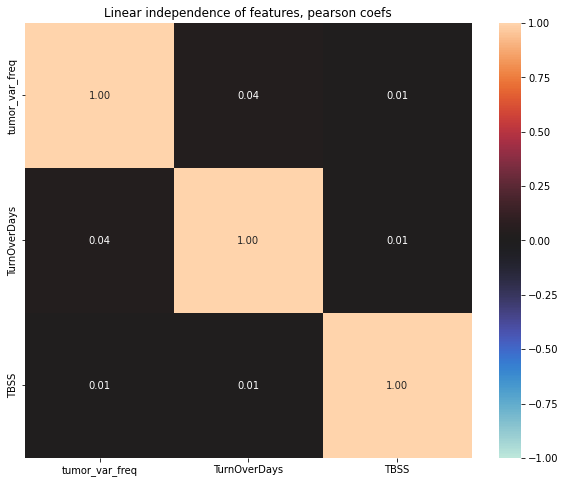

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutations[["tumor_var_freq", "TurnOverDays", "TBSS"]].corr(), annot=True, fmt=".2f", center=0, vmin=-1)
plt.title("Linear independence of features, pearson coefs")
plt.show()

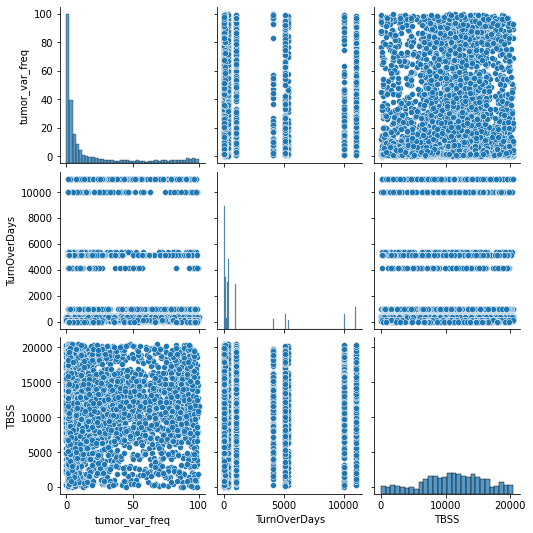

In [46]:
# Full independence of features
sns.pairplot(mutations[["tumor_var_freq", "TurnOverDays", "TBSS"]]);

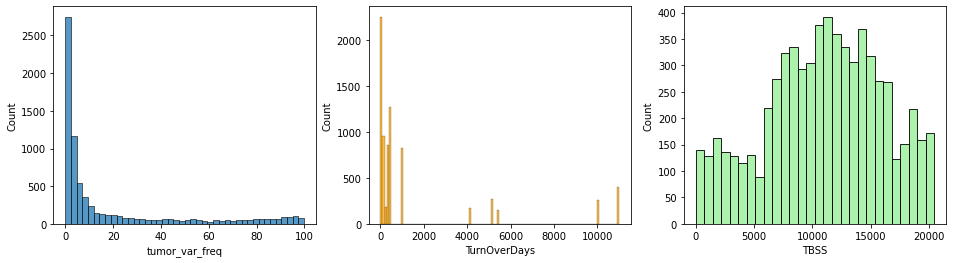

In [38]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
sns.histplot(mutations["tumor_var_freq"])
plt.subplot(132)
sns.histplot(mutations["TurnOverDays"], color="orange")
plt.subplot(133)
sns.histplot(mutations["TBSS"], color="lightgreen")
plt.show()

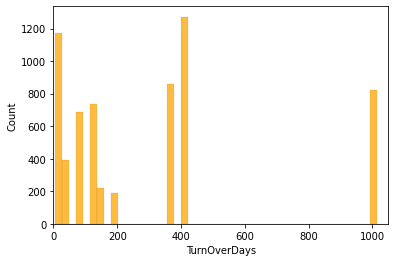

In [70]:
sns.histplot(mutations["TurnOverDays"], color="orange", bins=500, cumulative=False)
plt.xlim(0, 1050);

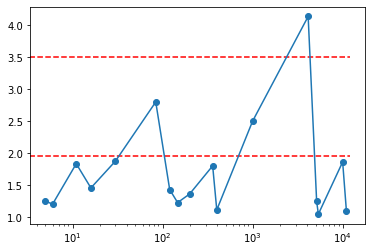

In [260]:
a = sorted(mutations.TurnOverDays.astype(int).unique())
shifts = [a[i + 1] / a[i] for i in range(len(a) - 1)]

plt.plot(a[1:], shifts, "o-")
plt.hlines(1.95, 0, 12000, "r", linestyle="--", )
plt.hlines(3.5, 0, 12000, "r", linestyle="--", )
plt.xscale("log")

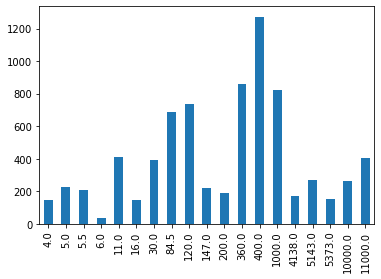

In [189]:
mutations.TurnOverDays.value_counts().sort_index().plot.bar();

### Add Dummy variables for hypoxia features

In [186]:
mutations["DummyVAF"] = 0
mutations.loc[(mutations.tumor_var_freq >= 5) & (mutations.tumor_var_freq < 10), "DummyVAF"] = 1
mutations.loc[(mutations.tumor_var_freq >= 10) & (mutations.tumor_var_freq < 20), "DummyVAF"] = 2
mutations.loc[(mutations.tumor_var_freq >= 20) & (mutations.tumor_var_freq < 50), "DummyVAF"] = 3
mutations.loc[(mutations.tumor_var_freq >= 50) & (mutations.tumor_var_freq < 70), "DummyVAF"] = 4
mutations.loc[(mutations.tumor_var_freq >= 70) & (mutations.tumor_var_freq < 80), "DummyVAF"] = 5
mutations.loc[(mutations.tumor_var_freq >= 80) & (mutations.tumor_var_freq < 90), "DummyVAF"] = 6
mutations.loc[mutations.tumor_var_freq >= 90, "DummyVAF"] = 7

tbss_quart = mutations.TBSS.max() // 4
print(tbss_quart)
mutations["DummyTBSS"] = 0
mutations.loc[(mutations.TBSS >= tbss_quart) & (mutations.TBSS < tbss_quart * 2), "DummyTBSS"] = 1
mutations.loc[(mutations.TBSS >= tbss_quart  * 2) & (mutations.TBSS < tbss_quart * 3), "DummyTBSS"] = 2
mutations.loc[mutations.TBSS >= tbss_quart * 3, "DummyTBSS"] = 3

# ???
mutations["DummyTurnOver"] = 0                                                                        # Tiny
mutations.loc[(mutations.TurnOverDays >= 50) & (mutations.TurnOverDays < 250), "DummyTurnOver"] = 1   # Small
mutations.loc[(mutations.TurnOverDays > 250) & (mutations.TurnOverDays < 500), "DummyTurnOver"] = 2   # Medium
mutations.loc[mutations.TurnOverDays == 1000, "DummyTurnOver"] = 3                                    # Large
mutations.loc[(mutations.TurnOverDays > 4000) & (mutations.TurnOverDays < 6000), "DummyTurnOver"] = 4 # Huge
mutations.loc[mutations.TurnOverDays > 8000, "DummyTurnOver"] = 5                                     # Eternal

5112.0


In [ ]:
# [0, 250]
# [250, 1000]
# [4000, 15000]

In [187]:
# mutations.drop([x for x in mutations.columns if x.startswith("Dummy")], axis=1, inplace=True)
mutations.DummyTurnOver.value_counts(), mutations.DummyVAF.value_counts(), mutations.DummyTBSS.value_counts()

(2    2134
 1    1834
 0    1566
 3     822
 5     664
 4     591
 Name: DummyTurnOver, dtype: int64,
 0    3974
 1     893
 3     836
 2     622
 4     398
 7     385
 6     285
 5     218
 Name: DummyVAF, dtype: int64,
 2    2447
 0    1958
 1    1836
 3    1370
 Name: DummyTBSS, dtype: int64)

In [188]:
mutations[mutations.Strand == -1].Type.value_counts()

D-loop    983
tRNA      205
CDS       171
Name: Type, dtype: int64

In [189]:
MutExDloop = mutations[(mutations.Type != "D-loop") & (mutations.Label >= 0)]  # & (mutations.Strand == 1)
print(mutations.shape)
print(MutExDloop.shape)

(7611, 19)
(6340, 19)


In [235]:
def cossimExDloop(mut1: pd.DataFrame, mut2: pd.DataFrame, sbs=None):
    ms1 = calculate_mutspec(mut1, trinucl_freqs["ExDloop"], "all", True, False)
    ms2 = calculate_mutspec(mut2, trinucl_freqs["ExDloop"], "all", True, False)
    if isinstance(sbs, str):
        assert bool(re.fullmatch("[ACGT]>[ACGT]", sbs))
        ms1 = ms1[ms1.Mut.str.contains(sbs)]
        ms2 = ms2[ms2.Mut.str.contains(sbs)]

    sim = 1 - spatial.distance.cosine(
        ms1.sort_values("Mut")["MutSpec"].values, 
        ms2.sort_values("Mut")["MutSpec"].values,
    )
    return sim

In [236]:
# DummyTurnOver [0, 5]
# DummyVAF      [0, 3]
# DummyTBSS     [0, 3]

In [192]:
# Low TurnOver VS High TurnOver

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 0)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver == 5)]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 0)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver > 0)]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 count = 1305
mut2 count = 571
cossim = 0.937

mut1 count = 1305
mut2 count = 5035
cossim = 0.976



In [193]:
mut1 = MutExDloop[
    (MutExDloop.DummyTurnOver > 2) &
    (MutExDloop.DummyVAF > 1)
]
mut2 = MutExDloop[
    (MutExDloop.DummyTurnOver <= 2) &
    (MutExDloop.DummyVAF <= 1)
]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 count = 585
mut2 count = 2978
cossim = 0.956



## Splitting machine
Searching for the best thresholds

In [259]:
def splitting_macine(feature, mut_num_cutoff=250, sbs=None):    
    values = sorted(MutExDloop[feature].unique())
    matrix_bound    = np.zeros((len(values), len(values)))
    matrix_pairwise = np.zeros((len(values), len(values)))
    data = []
    for b1 in values:
        for b2 in values[::-1]:
            if b1 == b2:
                break
            mut1 = MutExDloop[(MutExDloop[feature] <= b1)]
            mut2 = MutExDloop[(MutExDloop[feature] >= b2)]
            csim = cossimExDloop(mut1, mut2, sbs)
            matrix_bound[b2, b1] = csim
            matrix_pairwise[b2, b1] = cossimExDloop(
                MutExDloop[(MutExDloop[feature] == b1)], 
                MutExDloop[(MutExDloop[feature] == b2)],
                sbs
            )
            data.append({
                "b1": b1,
                "b2": b2,
                "mut_num1": mut1.shape[0],
                "mut_num2": mut2.shape[0],
                "cossim": csim,
            })
    minval = sorted(set(matrix_bound.flatten()) | set(matrix_pairwise.flatten()))[1]

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches((20, 8))
    fig.suptitle(feature if not isinstance(sbs, str) else feature + ", only " + sbs)
    sns.heatmap(matrix_bound, vmin=minval, vmax=1, annot=True, cmap="coolwarm", mask=matrix_bound == 0, ax=axs[0])
    axs[0].set_title("Bounds search")
    axs[0].set_ylabel("b2")
    axs[0].set_xlabel("b1")
    sns.heatmap(matrix_pairwise, vmin=minval, vmax=1, annot=True, cmap="coolwarm", mask=matrix_pairwise == 0, ax=axs[1])
    axs[1].set_title("Pairwise cossim")
    axs[1].set_ylabel("b2")
    axs[1].set_xlabel("b1")
    plt.show()
    
    df = pd.DataFrame(data).sort_values("cossim")
    df["enough_muts"] = (df.mut_num1 > mut_num_cutoff) & (df.mut_num2 > mut_num_cutoff)
    return df


def splitting_macine3d(feature1, feature2, mut_num_cutoff=250, sbs=None):
    values1 = sorted(MutExDloop[feature1].unique())
    values2 = sorted(MutExDloop[feature2].unique())
    data = []
    for b1 in values1:
        for b2 in values1[::-1]:
            if b1 == b2:
                break
            for d1 in values2:
                for d2 in values2[::-1]:
                    if d1 == d2:
                        break
                    mut1 = MutExDloop[
                        (MutExDloop[feature1] <= b1) &
                        (MutExDloop[feature2] <= d1)
                    ]
                    mut2 = MutExDloop[
                        (MutExDloop[feature1] >= b2) &
                        (MutExDloop[feature2] >= d2)
                    ]
                    csim = cossimExDloop(mut1, mut2, sbs)
                    data.append({
                        f"{feature1}_b1": b1,
                        f"{feature1}_b2": b2,
                        f"{feature2}_b1": d1,
                        f"{feature2}_b2": d2,
                        "mut_num1": mut1.shape[0],
                        "mut_num2": mut2.shape[0],
                        "cossim": csim,
                    })

    df = pd.DataFrame(data).sort_values("cossim")
    df["enough_muts"] = (df.mut_num1 > mut_num_cutoff) & (df.mut_num2 > mut_num_cutoff)
    return df

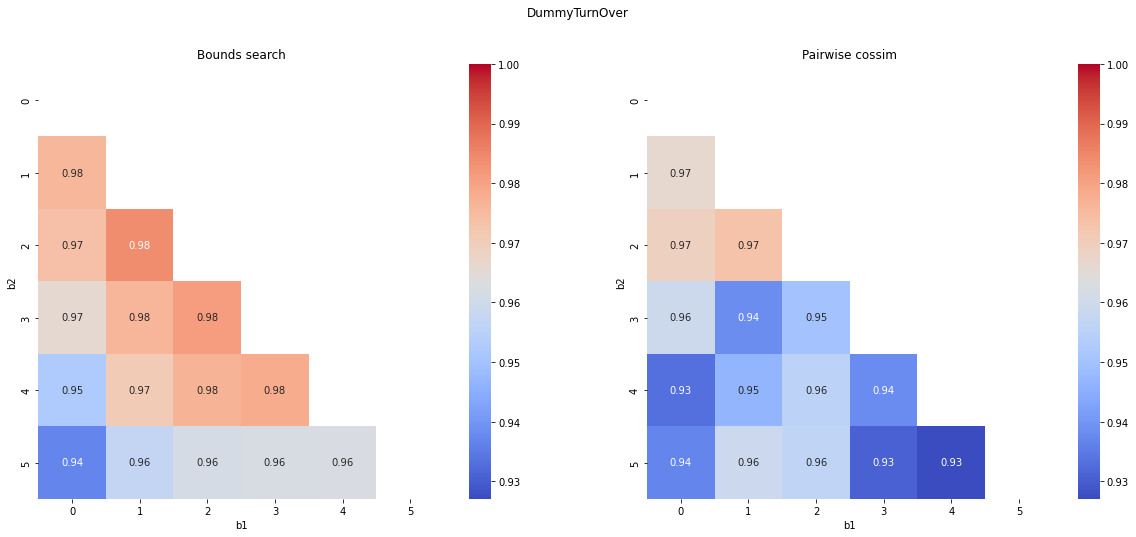

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,0,5,1305,571,0.936925,True
1,0,4,1305,1065,0.952584,True
5,1,5,2841,571,0.957146,True
9,2,5,4624,571,0.961509,True
12,3,5,5275,571,0.962072,True
14,4,5,5769,571,0.962220,True
2,0,3,1305,1716,0.966084,True
6,1,4,2841,1065,0.970817,True
3,0,2,1305,3499,0.973551,True
4,0,1,1305,5035,0.976015,True


In [260]:
splitting_macine("DummyTurnOver")

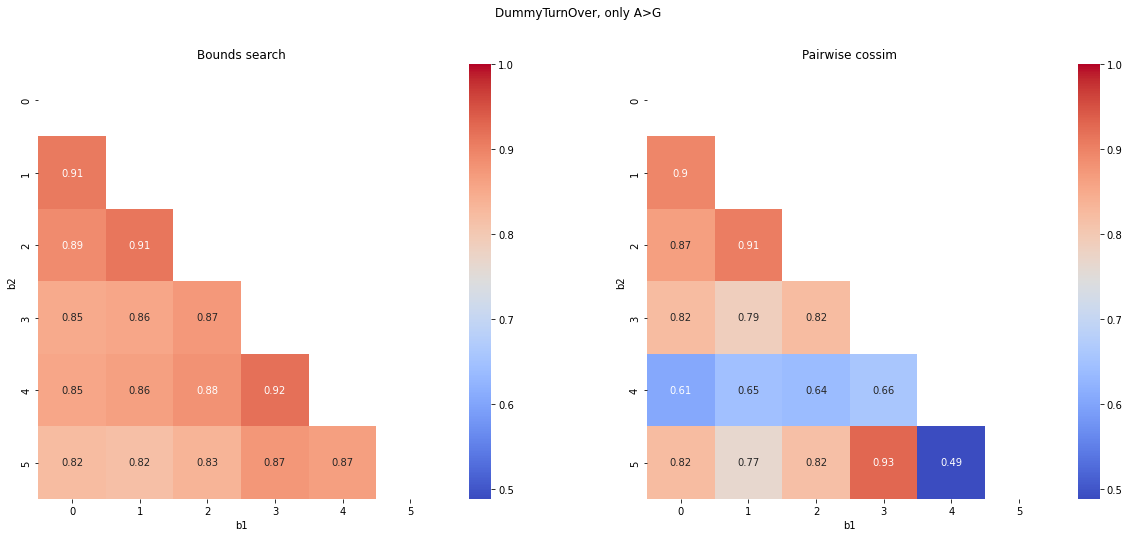

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
5,1,5,2841,571,0.816527,True
0,0,5,1305,571,0.822194,True
9,2,5,4624,571,0.834977,True
2,0,3,1305,1716,0.848862,True
1,0,4,1305,1065,0.854445,True
7,1,3,2841,1716,0.855319,True
6,1,4,2841,1065,0.862232,True
14,4,5,5769,571,0.865989,True
11,2,3,4624,1716,0.873550,True
12,3,5,5275,571,0.874758,True


In [261]:
splitting_macine("DummyTurnOver", sbs="A>G")

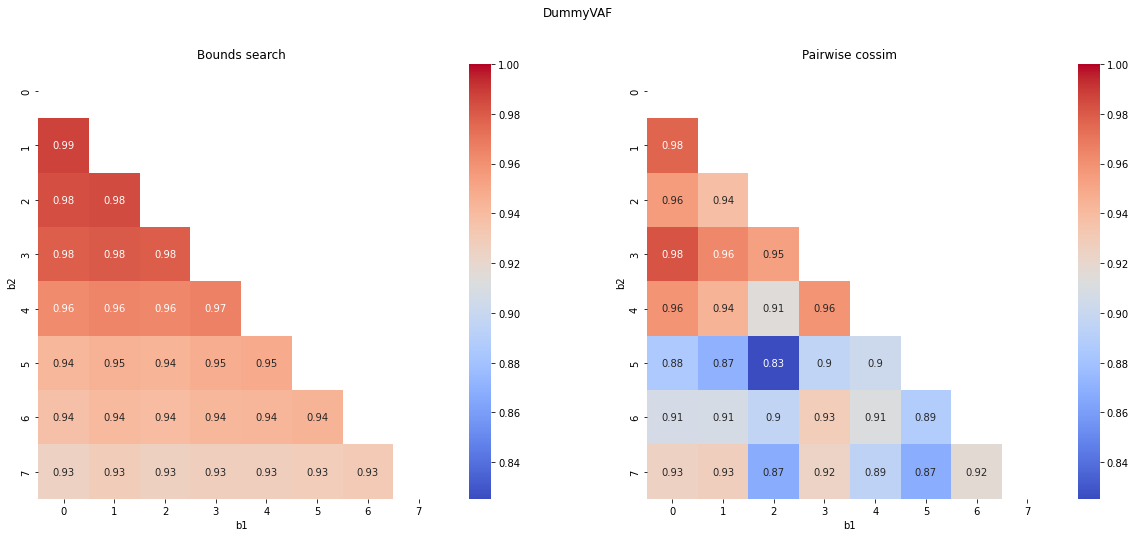

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,0,7,3307,275,0.925480,True
13,2,7,4656,275,0.925871,True
18,3,7,5371,275,0.927499,True
22,4,7,5691,275,0.927556,True
25,5,7,5857,275,0.928735,True
7,1,7,4109,275,0.929298,True
27,6,7,6065,275,0.930890,True
1,0,6,3307,483,0.936551,True
14,2,6,4656,483,0.939545,True
8,1,6,4109,483,0.940324,True


In [262]:
splitting_macine("DummyVAF")

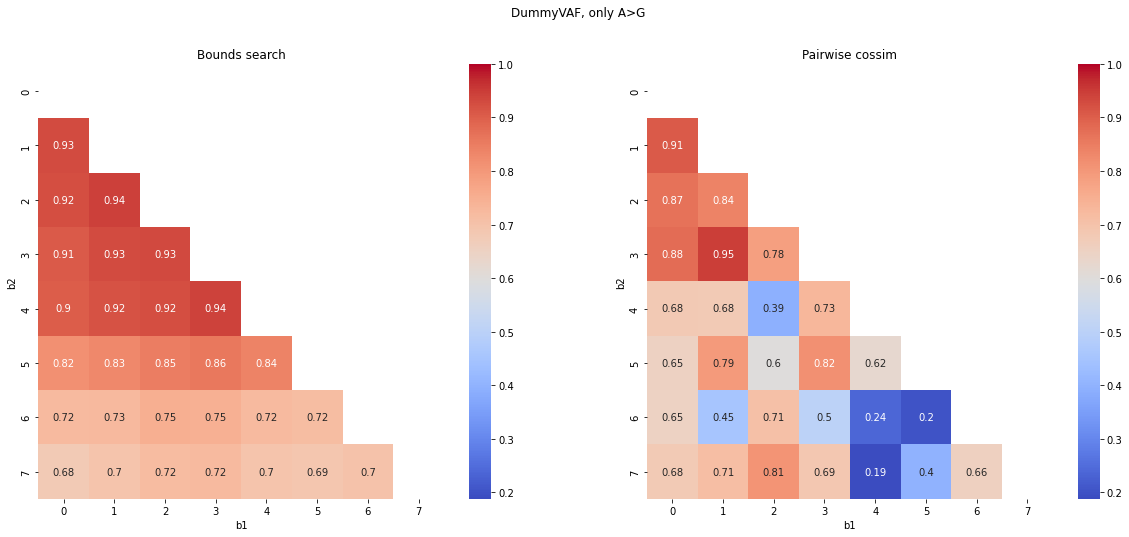

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,0,7,3307,275,0.676587,True
25,5,7,5857,275,0.691004,True
7,1,7,4109,275,0.695746,True
22,4,7,5691,275,0.697267,True
27,6,7,6065,275,0.701531,True
26,5,6,5857,483,0.715056,True
13,2,7,4656,275,0.719399,True
18,3,7,5371,275,0.723687,True
1,0,6,3307,483,0.723762,True
23,4,6,5691,483,0.724016,True


In [263]:
splitting_macine("DummyVAF", sbs="A>G")

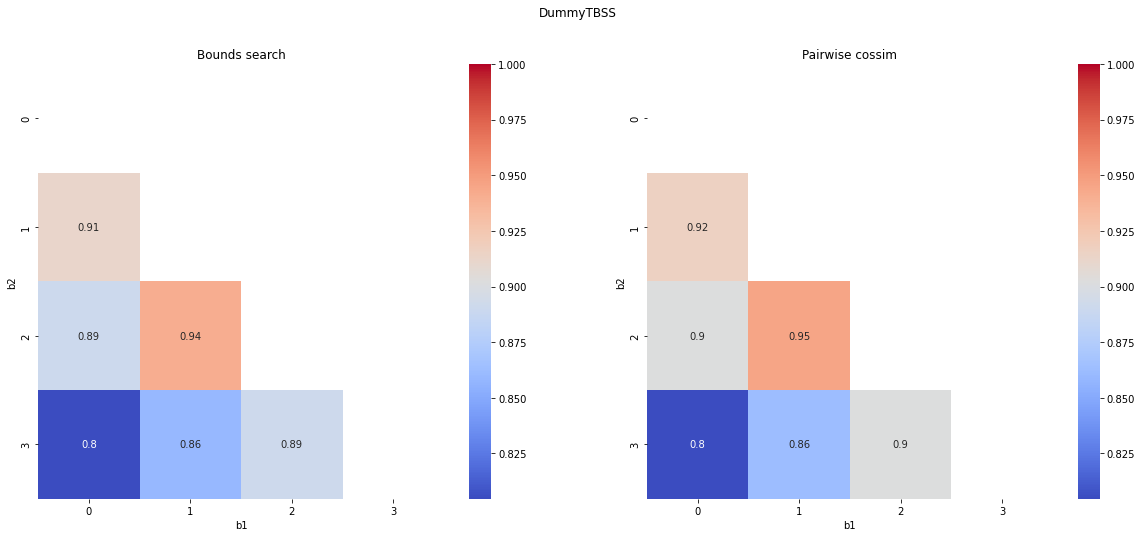

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,0,3,906,1297,0.804642,True
3,1,3,2690,1297,0.859480,True
1,0,2,906,3650,0.890177,True
5,2,3,5043,1297,0.891275,True
2,0,1,906,5434,0.911825,True
4,1,2,2690,3650,0.940575,True


In [264]:
splitting_macine("DummyTBSS")
# be carefull, mutspecs normalized on the same mutations excluding genome positioning, that is nessesary in case of TBSS

In [216]:
pair = splitting_macine3d("DummyTurnOver", "DummyVAF")

In [217]:
pair[pair.enough_muts].head(10)

,DummyTurnOver_b1,DummyTurnOver_b2,DummyVAF_b1,DummyVAF_b2,mut_num1,mut_num2,cossim,enough_muts
59,0,3,0,4,649,255,0.854742,True
66,0,3,1,4,796,255,0.863385,True
39,0,4,1,3,796,312,0.870306,True
32,0,4,0,3,649,312,0.870746,True
72,0,3,2,4,898,255,0.872457,True
77,0,3,3,4,1057,255,0.873416,True
199,1,3,0,4,1436,255,0.878299,True
45,0,4,2,3,898,312,0.880088,True
120,0,1,1,6,796,342,0.886686,True
6,0,5,0,1,649,300,0.889646,True


In [ ]:
def sample_mutations():
    """bootstrap vs permutations"""
    pass


def compare_signuficantly():
    pass

In [376]:
mut1.head(10).sample(10, replace=True)  # for permutations

,tissue,is_nonsense,sbs_raw,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,...,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut,DummyTurnOver,DummyVAF,DummyTBSS
162,Thyroid,0,nTC>TG,4138.0,98.21,3380,G,CGA,1,CDS,...,74,2,CGA,11887.0,CAA,0,C[G>A]A,4,3,2
162,Thyroid,0,nTC>TG,4138.0,98.21,3380,G,CGA,1,CDS,...,74,2,CGA,11887.0,CAA,0,C[G>A]A,4,3,2
160,Lung,0,nTC>TG,5143.0,62.92,3380,G,CGA,1,CDS,...,74,2,CGA,11887.0,CAA,0,C[G>A]A,4,2,2
51,Lung,0,pGT>CT,5143.0,81.25,7998,T,GTT,1,CDS,...,413,2,GTT,4400.0,GCT,0,G[T>C]T,4,3,0
39,Lung,0,pTT>CC,5143.0,94.59,3098,T,TTC,1,rRNA,...,-1,-1,NaN,11323.0,None,0,T[T>C]C,4,3,2
515,Bone/SoftTissue,0,nGC>TC,5373.0,90.42,1362,G,GGC,1,rRNA,...,-1,-1,NaN,7851.0,None,0,G[G>A]C,4,3,1
290,Bone/SoftTissue,0,nGC>TG,5373.0,81.37,3460,G,CGC,1,CDS,...,154,1,GCC,12047.0,ACC,0,C[G>A]C,4,3,2
417,Ovary,0,nGC>TT,11000.0,97.65,4794,G,AGC,1,CDS,...,325,1,GCC,14715.0,ACC,0,A[G>A]C,5,3,2
289,Bone/SoftTissue,0,pCT>CT,5373.0,82.02,13964,T,CTT,1,CDS,...,1628,2,CTT,16332.0,CCT,0,C[T>C]T,4,3,3
160,Lung,0,nTC>TG,5143.0,62.92,3380,G,CGA,1,CDS,...,74,2,CGA,11887.0,CAA,0,C[G>A]A,4,2,2


## Plan

1. (done) VAF & TurnOver trashholds machine
2. (done) Compare only A>G 
3. pvalue
4. context for TBSS (optional)
